# Jupiter Processing

In [1]:
# Import Statements
import os
import glob
import numpy as np
from photutils.detection import DAOStarFinder
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass
from photutils.aperture import aperture_photometry, CircularAperture
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.time import Time

%matplotlib inline
plt.style.use('seaborn-v0_8-muted')

In [2]:
# parent directory leading to all of the child directories
base_path = 'C:/Users/Austin/ObsTech/Lab 5/Jupiter/'

# bias directory
bias_dir = base_path + 'Bias_231101/2023-11-01_21_46_54Z/'
bias_files = os.listdir(bias_dir)

# dark directory
darks_dir = base_path + 'Darks_0.001/2023-11-01_21_42_51Z/'
darks_files = os.listdir(darks_dir)

# flats directory
B_flat_dir = base_path + 'Flats_231101/B_filter/2023-11-01_18_59_05Z/'
B_flat_files = os.listdir(B_flat_dir)

I_flat_dir = base_path + 'Flats_231101/I_filter/2023-11-01_19_11_05Z/'
I_flat_files = os.listdir(I_flat_dir)

R_flat_dir = base_path + 'Flats_231101/R_filter/2023-11-01_19_05_03Z/'
R_flat_files = os.listdir(R_flat_dir)

V_flat_dir = base_path + 'Flats_231101/V_filter/2023-11-01_19_01_51Z/'
V_flat_files = os.listdir(V_flat_dir)

# Different filters
B_dir = base_path + 'B_filter/Light/2023-11-01_21_31_34Z/'
B_files = os.listdir(B_dir)

R_dir = base_path + 'R_filter/Light/2023-11-01_21_35_05Z/'
R_files = os.listdir(R_dir)

V_dir = base_path + 'V_filter/Light/2023-11-01_21_38_05Z/'
V_files = os.listdir(V_dir)

In [3]:
# mean bias image
from astropy import visualization

bias_file_list = glob.glob(bias_dir + '*fits')
bias_timeseries = np.array([fits.getdata(file) for file in bias_file_list])
bias_median_image = np.median(bias_timeseries, axis=0)
master_bias = bias_median_image
bias_std = np.std(bias_median_image, axis=0) # bias noise array
master_bias_std = np.round(np.std(master_bias), 2) # bias "mean" std
print(f'The standard deviation of the master bias is {master_bias_std}.')

The standard deviation of the master bias is 3.55.


In [4]:
# Created a master dark for Jupiter, and computed the standard deviation of the stacked darks.
calibrated_darks = np.array([fits.getdata(darks_dir + file) - master_bias for file in darks_files])
master_dark = np.median(calibrated_darks, axis=0)
dark_std = np.std(calibrated_darks, axis=0)
master_dark_std = np.round(np.mean(np.std(calibrated_darks, axis=0)), 2) # dark "mean" std
print(f'The standard deviation of the master dark frame is {master_dark_std}.')
print(master_dark.shape)

The standard deviation of the master dark frame is 5.47.
(1411, 2072)


In [5]:
def master_flat(flats_dir, flats_files, master_bias):
    """
    Stack the flat frames of a given color filter, and take the median across them
    in order to create the master flat frame for each respective filter.
    """
    
    calibrated_flats = np.array([fits.getdata(flats_dir + file) - master_bias for file in flats_files])
    master_flat = np.mean(calibrated_flats, axis=0)
    normalized_master_flat = master_flat / np.mean(master_flat)
    # std_flat = np.round(np.mean(np.std(calibrated_flats, axis=0)), 0)
    std_flat = np.std(normalized_master_flat, axis=0)
    
    return normalized_master_flat, std_flat

master_B_flat, B_flat_std = master_flat(B_flat_dir, B_flat_files, master_bias)
master_V_flat, V_flat_std = master_flat(V_flat_dir, V_flat_files, master_bias)
master_R_flat, R_flat_std = master_flat(R_flat_dir, R_flat_files, master_bias)
# print(f'The standard deviation of the B filter master flat is {B_flat_std}.')
# print(f'The standard deviation of the V filter master flat is {V_flat_std}.')
# print(f'The standard deviation of the R filter master flat is {R_flat_std}.')

In [6]:
def center_of_flux(directory, file_list, master_bias, master_dark, master_flat):
    """
    Calculate the center of flux for an entire directory of Jupiter images (filter images)
    Solving the center of flux problem before discovering the scipy function.
    """
    
    center_of_flux_list = []
    
    # Center of flux calculations
    for file in file_list:
        data = np.array((fits.getdata(directory + file) - master_bias - master_dark) / master_flat)
        data = data[500:950, 900:1300] # cropped array to avoid misalignment from bright pixels
        Z = np.sum(data)
        y = 0
        x = 0
        y_vals = 0
        x_vals = 0
        
        for row in data:
            total_flux = np.sum(row)
            y_vals += y*total_flux
            y += 1
        
        for col in data.T:
            total_flux = np.sum(col)
            x_vals += x*total_flux
            x += 1
            
        center_of_flux_list.append(np.array([y_vals/Z, x_vals/Z]))
        
    return center_of_flux_list


def master_filter(directory, file_list, master_bias, master_dark, master_flat):
    """
    Combine all images for one filter of Jupiter, taking the median down axis 0.
    """

    center_of_flux_vals = center_of_flux(directory, file_list, master_bias, master_dark, master_flat)

    reference = np.array((fits.getdata(directory + file_list[0]) - master_bias - master_dark) / master_flat)
    aligned_images = [reference]

    for i in range(len(file_list[1:])):
        rolled_image = np.array((fits.getdata(directory + file_list[i]) - master_bias - master_dark) / master_flat)
        shift = center_of_flux_vals[0] - center_of_flux_vals[i]
        rolled_image = np.roll(rolled_image, shift=shift.astype(int), axis=(0, 1))
        aligned_images.append(rolled_image)
        
    # Error because you made me
    aligned_images = np.array([array for array in aligned_images])
    master_filter = np.median(aligned_images, axis=0)
    
    return master_filter

# Jupiter B Filter

The average SNR of the Jupiter B frame is 0.0208.


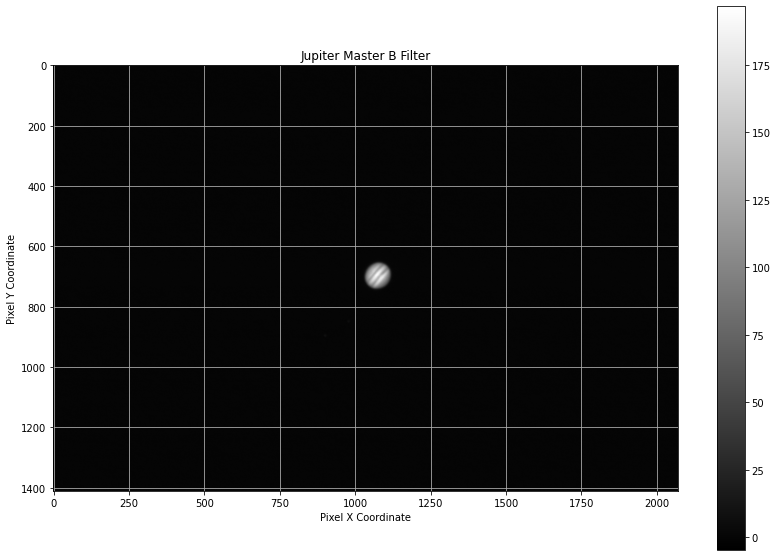

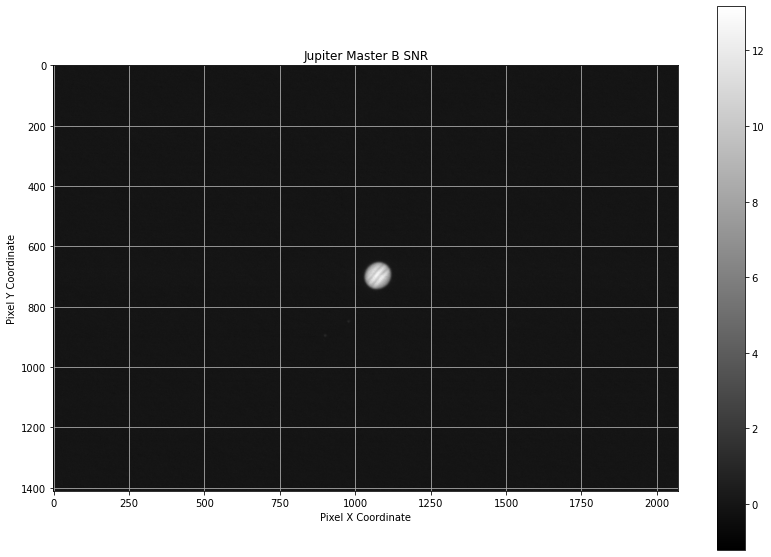

In [7]:
master_filter_B = master_filter(B_dir, B_files, master_bias, master_dark, master_B_flat)
plt.figure(figsize=(14, 10))
plt.imshow(master_filter_B, cmap='gray', alpha=1.0)
plt.colorbar()
plt.grid(None)
_=plt.title('Jupiter Master B Filter')
_=plt.xlabel('Pixel X Coordinate')
_=plt.ylabel('Pixel Y Coordinate')

SNR_JB = master_filter_B / np.sqrt(master_filter_B + dark_std**2 + bias_std**2 + B_flat_std**2)
mean_SNR_JB = np.round(np.mean(SNR_JB), 4)
print(f'The average SNR of the Jupiter B frame is {mean_SNR_JB}.')
plt.figure(figsize=(14, 10))
plt.imshow(SNR_JB, cmap='gray', alpha=1.0)
plt.colorbar()
plt.grid(None)
_=plt.title('Jupiter Master B SNR')
_=plt.xlabel('Pixel X Coordinate')
_=plt.ylabel('Pixel Y Coordinate')

# Jupiter V Filter

The average SNR of the Jupiter V frame is 0.0267.


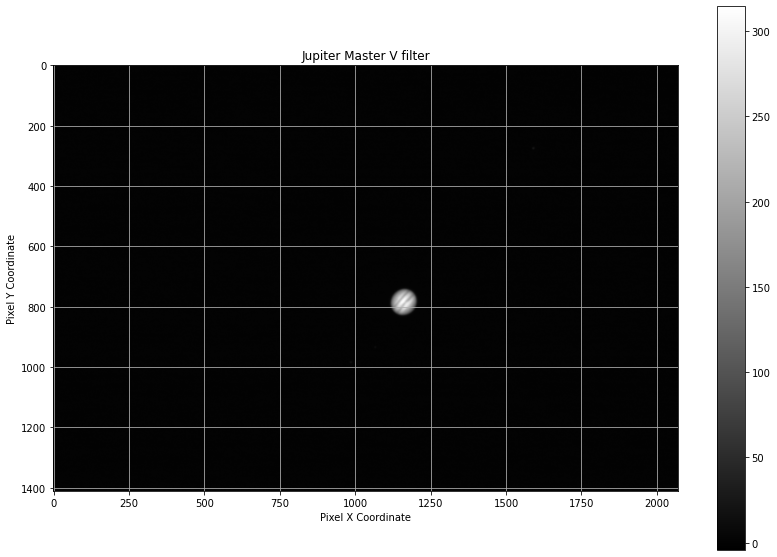

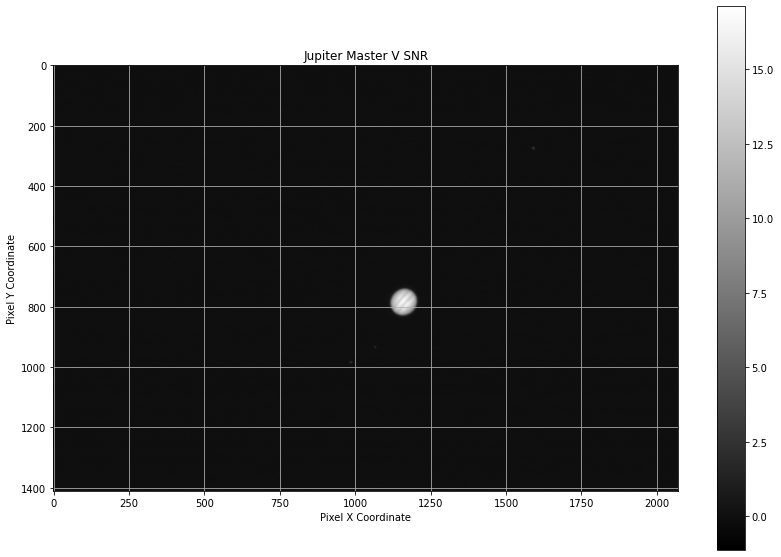

In [8]:
master_filter_V = master_filter(V_dir, V_files, master_bias, master_dark, master_V_flat)

plt.figure(figsize=(14, 10))
plt.imshow(master_filter_V, cmap='gray', alpha=1.0)
plt.colorbar()
plt.grid(None)
_=plt.title('Jupiter Master V filter')
_=plt.xlabel('Pixel X Coordinate')
_=plt.ylabel('Pixel Y Coordinate')

SNR_JV = master_filter_V / np.sqrt(master_filter_V + dark_std**2 + bias_std**2 + V_flat_std**2)
mean_SNR_JV = np.round(np.mean(SNR_JV), 4)
print(f'The average SNR of the Jupiter V frame is {mean_SNR_JV}.')
plt.figure(figsize=(14, 10))
plt.imshow(SNR_JV, cmap='gray', alpha=1.0)
plt.colorbar()
plt.grid(None)
_=plt.title('Jupiter Master V SNR')
_=plt.xlabel('Pixel X Coordinate')
_=plt.ylabel('Pixel Y Coordinate')

# Jupiter R Filter

The average SNR of the Jupiter R frame is 0.0355.


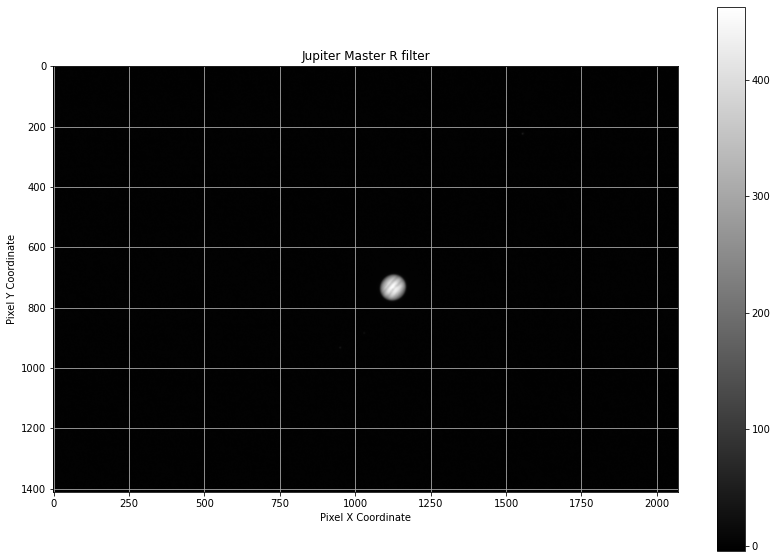

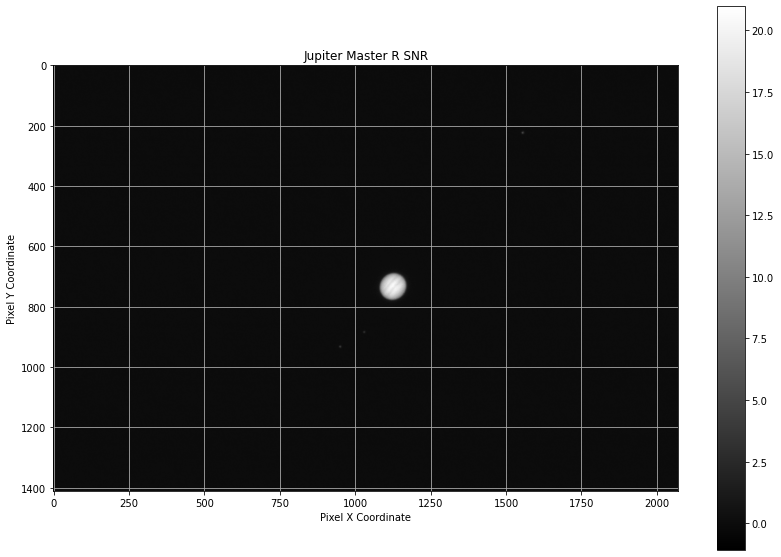

In [9]:
master_filter_R = master_filter(R_dir, R_files, master_bias, master_dark, master_R_flat)

plt.figure(figsize=(14, 10))
plt.imshow(master_filter_R, cmap='gray', alpha=1.0)
plt.colorbar()
plt.grid(None)
_=plt.title('Jupiter Master R filter')
_=plt.xlabel('Pixel X Coordinate')
_=plt.ylabel('Pixel Y Coordinate')

SNR_JR = master_filter_R / np.sqrt(master_filter_R + dark_std**2 + bias_std**2 + R_flat_std**2)
mean_SNR_JR = np.round(np.mean(SNR_JR), 4)
print(f'The average SNR of the Jupiter R frame is {mean_SNR_JR}.')
plt.figure(figsize=(14, 10))
plt.imshow(SNR_JR, cmap='gray', alpha=1.0)
plt.colorbar()
plt.grid(None)
_=plt.title('Jupiter Master R SNR')
_=plt.xlabel('Pixel X Coordinate')
_=plt.ylabel('Pixel Y Coordinate')

In [10]:
# Roll the master R and V frames on top of the master B frame
# cropping helps with the alignment, negates bright pixels.

master_R_cropped = master_filter_R[500:900, 950:1250]
master_V_cropped = master_filter_V[500:900, 950:1250]
master_B_cropped = master_filter_B[500:900, 950:1250]


R_com = center_of_mass(master_R_cropped)
V_com = center_of_mass(master_V_cropped)
B_com = center_of_mass(master_B_cropped)


shift_R = np.array(B_com) - np.array(R_com)
shift_V = np.array(B_com) - np.array(V_com)


master_R_rolled = np.roll(master_filter_R, shift=shift_R.astype(int), axis=(0, 1))
master_V_rolled = np.roll(master_filter_V, shift=shift_V.astype(int), axis=(0, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01992415475306088..1.0].


(np.float64(694.992301630784), np.float64(1075.691855916022), np.float64(0.9966501320528484))


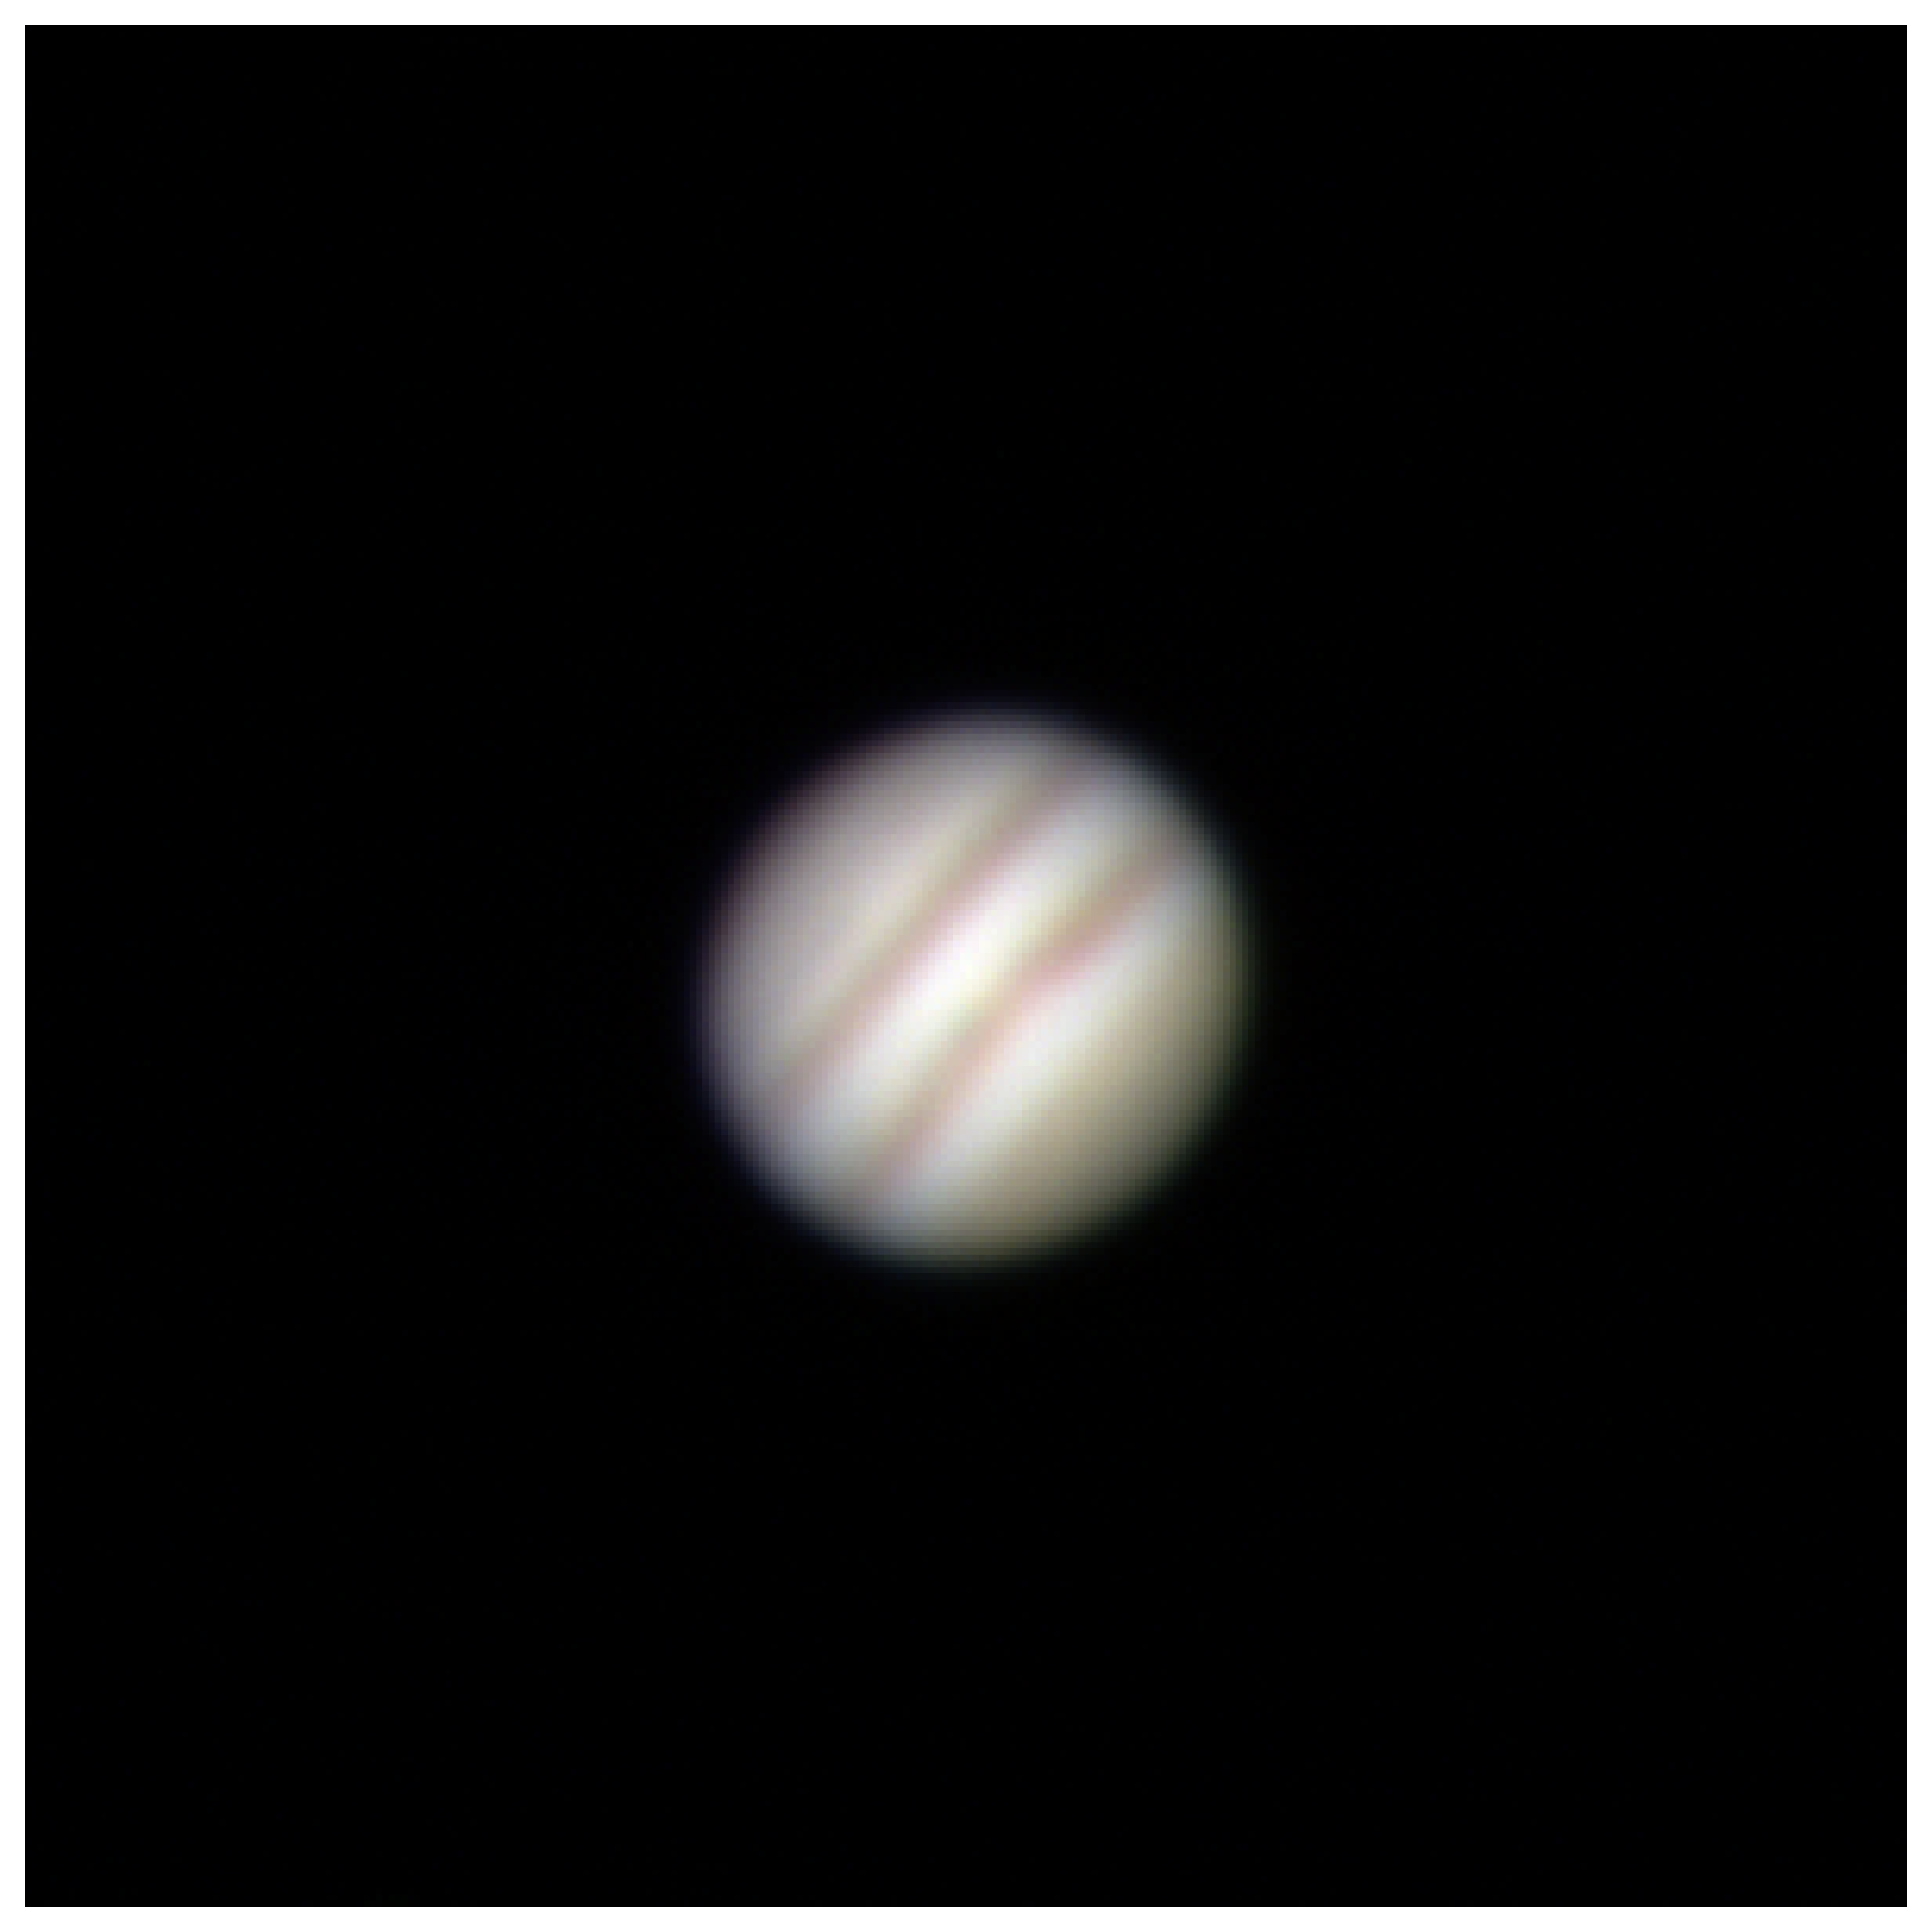

In [15]:
# Divide Jupiter by the brightest pixel to normalize and get rid of static.
import PIL

master_R_normalized = master_R_rolled / master_R_rolled.max()
master_V_normalized = master_V_rolled / master_V_rolled.max()
master_B_normalized = master_filter_B / master_filter_B.max()
master_science = (master_R_normalized, master_V_normalized, master_B_normalized)
color_image = np.dstack(master_science)
color_image_com = center_of_mass(color_image)
print(color_image_com)

fig, ax = plt.subplots(figsize=(10, 10), frameon=False, dpi=300)
ax.imshow(color_image[544:844, 926:1226])
ax.set_axis_off()
ax.grid(None)
plt.savefig('jupie.png')

# img = PIL.Image.open('jupie.png')
# converter = PIL.ImageEnhance.Color(img)
# img2 = converter.enhance(2)
# converter = PIL.ImageEnhance.Sharpness(img2)
# img3 = converter.enhance(5)

# fig, ax = plt.subplots(figsize=(10, 10), frameon=False, dpi=300)
# ax.imshow(img3)
# ax.set_axis_off()
# ax.grid(None)
# plt.savefig('jupie_edited.png')

# Star Processing: HD219134 and Vega

In [ ]:
# Directories
base_path = 'C:/Users/Austin/ObsTech/Lab 5/star_data/'

# Vega directory
vega_bias_dir = base_path + 'Vega/ReadNoise/Files/'
vega_bias_files = os.listdir(vega_bias_dir)

vega_darks_dir = base_path + 'Vega/DarkVega/'
vega_darks_files = os.listdir(vega_darks_dir)

vega_B_flats_dir = base_path + 'Vega/FlatBrightVega/B filter/'
vega_B_flats_files = os.listdir(vega_B_flats_dir)

vega_V_flats_dir = base_path + 'Vega/FlatBrightVega/V filter/'
vega_V_flats_files = os.listdir(vega_V_flats_dir)

vega_I_flats_dir = base_path + 'Vega/FlatBrightVega/I filter/'
vega_I_flats_files = os.listdir(vega_I_flats_dir)

vega_B_dir = base_path + 'Vega/LightVega/B_filter/'
vega_B_files = os.listdir(vega_B_dir)

vega_V_dir = base_path + 'Vega/LightVega/V_filter/'
vega_V_files = os.listdir(vega_V_dir)

vega_I_dir = base_path + 'Vega/LightVega/I_filter/'
vega_I_files = os.listdir(vega_I_dir)

# HD219134 directory
HD_bias_dir = base_path + 'HD219134/Bias/2023-11-01_21_46_54Z/'
HD_bias_files = os.listdir(HD_bias_dir)

HD_darks_dir = base_path + 'HD219134/Darks/2023-11-01_21_44_18Z/'
HD_darks_files = os.listdir(HD_darks_dir)

HD_R_flats_dir = base_path + 'HD219134/Flats/R_filter/2023-11-01_19_05_03Z/'
HD_R_flats_files = os.listdir(HD_R_flats_dir)

HD_R_dir_1 = base_path + 'HD219134/2023-11-01-R_filter_216_exposures_part1/'
HD_R_dir_2 = base_path + 'HD219134/2023-11-01-R_filter_216_exposures_part2/'
HD_R_files1 = os.listdir(HD_R_dir_1)
HD_R_files2 = os.listdir(HD_R_dir_2)

In [ ]:
# Master bias frame for HD219314
HD_bias_file_list = glob.glob(HD_bias_dir + '*fits')
HD_bias_timeseries = np.array([fits.getdata(file) for file in HD_bias_file_list])
HD_bias_median_image = np.median(HD_bias_timeseries, axis=0)
HD_master_bias = HD_bias_median_image
print(HD_master_bias.shape)

In [ ]:
# Master dark frame for HD219314
HD_calibrated_darks = np.array([fits.getdata(HD_darks_dir + file) - HD_master_bias for file in HD_darks_files])
HD_master_dark = np.median(HD_calibrated_darks, axis=0)
print(HD_master_dark.shape)

In [ ]:
# Raw HD219134 Light Frames
light_HD = fits.getdata(HD_R_dir_1 + HD_R_files1[0])

mean, median, std = sigma_clipped_stats(light_HD, sigma=3.0) 
print((mean, median, std)) 

norm_scale = ImageNormalize(light_HD, interval=ZScaleInterval())

plt.figure(figsize=(14, 10))
plt.imshow(light_HD, origin='lower', cmap='gray', norm=norm_scale)
plt.colorbar()
_=plt.title('HD219134')
_=plt.xlabel('Pixel X Coordinate')
_=plt.ylabel('Pixel Y Coordinate')

In [ ]:
# Create a master R flat for HD
HD_master_flat = master_flat(HD_R_flats_dir, HD_R_flats_files, HD_master_bias)[0]
print(HD_master_flat.shape)


# Process the HD images
def processed_HD(directory, file_name):
    processed_image = np.array((fits.getdata(directory + file_name) - HD_master_bias - HD_master_dark) / HD_master_flat)
    return processed_image


def HD_flux(directory, file_name, show_plot=False):
    science_frame = processed_HD(directory, file_name)
    mean, median, std = sigma_clipped_stats(science_frame, sigma=3.0)
    norm_scale = ImageNormalize(science_frame, interval=ZScaleInterval())
    
    if show_plot == True:
        plt.figure(figsize=(14, 10))
        plt.imshow(science_frame-median, origin='lower', cmap='gray', norm=norm_scale)
        plt.colorbar()
        _=plt.title('HD219134')
        _=plt.xlabel('Pixel X Coordinate')
        _=plt.ylabel('Pixel Y Coordinate')
        
    daofind = DAOStarFinder(fwhm=3.0, threshold=5*std)  
    sources = daofind(science_frame)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    aperture_radius = 10    
    apertures = CircularAperture(positions, r=aperture_radius)    
    phot_table = aperture_photometry(science_frame, apertures)
    
    maximum_brightness = phot_table['aperture_sum'].max()
    
    return maximum_brightness


def extract_time_in_JD(directory, file):
    
    # Make the time axis
    header = fits.getheader(directory + file)
    julian_date = Time(header['DATE-OBS']).jd
    
    return julian_date
    
science_frame = processed_HD(HD_R_dir_1, HD_R_files1[11])
mean, median, std = sigma_clipped_stats(science_frame, sigma=8.0) 
print((mean, median, std)) 

norm_scale = ImageNormalize(science_frame, interval=ZScaleInterval())

plt.figure(figsize=(14, 10))
plt.imshow(science_frame-median, origin='lower', cmap='gray', norm=norm_scale)
#plt.colorbar()
plt.savefig('HD219134_starfield.png', dpi=300)

In [ ]:
daofind = DAOStarFinder(fwhm=1.5, threshold=5*std)  
sources = daofind(science_frame)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

sources

In [ ]:
norm_scale = ImageNormalize(science_frame, interval=ZScaleInterval())
plt.imshow(science_frame-median,origin='lower', cmap='gray_r', norm=norm_scale) #, cmap='gray_r', origin='lower', vmin=0, vmax=2500)
apertures = CircularAperture(positions, r=10.0)
apertures.plot(color='blue', lw=5.5, alpha=0.3)
plt.savefig('HD219134_apertures.png', dpi=300)

In [ ]:
aperture_radius=15    
apertures = CircularAperture(positions, r=aperture_radius)    
phot_table = aperture_photometry(science_frame, apertures)     
phot_table

In [ ]:
maximum_brightness = phot_table['aperture_sum'].max()
print(maximum_brightness)

In [ ]:
time_series = []
brightness_vals = []
for file in HD_R_files1:
    time = extract_time_in_JD(HD_R_dir_1, file)
    flux = HD_flux(HD_R_dir_1, file)
    time_series.append(time)
    brightness_vals.append(flux)

for file in HD_R_files2:
    time = extract_time_in_JD(HD_R_dir_2, file)
    flux = HD_flux(HD_R_dir_2, file)
    time_series.append(time)
    brightness_vals.append(flux)

brightness = np.array(brightness_vals)
brightness_vals_normalized = np.array(brightness_vals) / np.mean(brightness_vals)
brightness_vals_normalized[brightness_vals_normalized < 0.2] = np.median(brightness_vals_normalized)
brightness_vals_normalized[brightness_vals_normalized > 1.5] = np.median(brightness_vals_normalized)

time_series, brightness_vals_normalized = zip(*sorted(zip(time_series, brightness_vals_normalized)))

In [ ]:
def bin_LC(time_data, flux_data, bin_size=2):
    """ Given time series data for a stellar light curve, bin data points according to bin size. """
    new_time_series = np.array_split(time_data, len(time_data)/bin_size)
    new_flux_array = np.array_split(flux_data, len(flux_data)/bin_size)
    binned_time = np.array([np.mean(time) for time in new_time_series])
    binned_flux = np.array([np.mean(flux) for flux in new_flux_array])
    
    return binned_time, binned_flux

In [ ]:
sigma16 = np.std(bin_LC(time_series, brightness, bin_size=16)[1])
print(sigma16)

# HD219134 Light Curve (bin size = 1, or unbinned)

In [ ]:
plt.figure(figsize=(14, 10), dpi=300)
plt.scatter(time_series, brightness_vals_normalized)
plt.xlabel('JD')
plt.ylabel('Flux')
plt.ylim([0.4, 1.6])
plt.title('HD219134 Light Curve')
plt.savefig('HD219134_LC.png', dpi=300)

sigma1 = np.std(brightness_vals_normalized)
print(sigma1)

In [ ]:
def bin_LC(time_data, flux_data, bin_size=2):
    """ Given time series data for a stellar light curve, bin data points according to bin size. """
    new_time_series = np.array_split(time_data, len(time_data)/bin_size)
    new_flux_array = np.array_split(flux_data, len(flux_data)/bin_size)
    binned_time = np.array([np.mean(time) for time in new_time_series])
    binned_flux = np.array([np.mean(flux) for flux in new_flux_array])
    
    return binned_time, binned_flux

# HD219134 Light Curve (bin size = 2)

In [ ]:
t2, F2 = bin_LC(time_series, brightness_vals_normalized, bin_size=2)

plt.figure(figsize=(14, 10), dpi=300)
plt.scatter(t2, F2)
plt.xlabel('JD')
plt.ylabel('Flux')
plt.ylim([0.4, 1.6])
plt.title('HD219134 Light Curve (bin size = 2)')
plt.savefig('HD219134_LC_bin_size2.png', dpi=300)

sigma2 = np.std(F2)
print(f'The standard deviation of the normalized flux for bin size 2 is {sigma2}.')

# HD219134 Light Curve (bin size = 4)

In [ ]:
t4, F4 = bin_LC(time_series, brightness_vals_normalized, bin_size=4)

plt.figure(figsize=(14, 10), dpi=300)
plt.scatter(t4, F4)
plt.xlabel('JD')
plt.ylabel('Flux')
plt.ylim([0.4, 1.6])
plt.title('HD219134 Light Curve (bin size = 4)')
plt.savefig('HD219134_LC_bin_size4.png', dpi=300)

sigma4 = np.std(F4)
print(f'The standard deviation of the normalized flux for bin size 4 is {sigma4}.')

# HD219134 Light Curve (bin size = 8)

In [ ]:
t8, F8 = bin_LC(time_series, brightness_vals_normalized, bin_size=8)

plt.figure(figsize=(14, 10), dpi=300)
plt.scatter(t8, F8)
plt.xlabel('JD')
plt.ylabel('Flux')
plt.ylim([0.4, 1.6])
plt.title('HD219134 Light Curve (bin size = 8)')
plt.savefig('HD219134_LC_bin_size8.png', dpi=300)

sigma8 = np.std(F8)
print(f'The standard deviation of the normalized flux for bin size 8 is {sigma8}.')

# HD219134 Light Curve (bin size = 16)

In [ ]:
t16, F16 = bin_LC(time_series, brightness_vals_normalized, bin_size=16)

plt.figure(figsize=(14, 10), dpi=300)
plt.scatter(t16, F16)
plt.xlabel('JD')
plt.ylabel('Flux')
plt.ylim([0.4, 1.6])
plt.title('HD219134 Light Curve (bin size = 16)')
plt.savefig('HD219134_LC_bin_size16.png', dpi=300)

sigma16 = np.std(F16)
print(f'The standard deviation of the normalized flux for bin size 16 is {sigma16}.')
print(sigma16/np.mean(F16) * 1e6)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=300)

bin_sizes = [1, 2, 4, 8, 16]
sigmas = [sigma1, sigma2, sigma4, sigma8, sigma16]
x = np.linspace(1, 16, 1000)

ax1.scatter(bin_sizes, sigmas, edgecolor='black', lw=1)
ax1.plot(x, sigmas[0]/np.sqrt(x))
ax1.set_title('Standard Devation as a Function of Bin Size')
ax1.set_xlabel('Bin Size')
ax1.set_ylabel(r'$\sigma_{bin}$')

ax2.scatter(time_series, brightness_vals_normalized, edgecolor='black', lw=1, label=r'$\sigma_{1}$')
ax2.scatter(t2, F2, edgecolor='black', lw=1, label=r'$\sigma_{2}$')
ax2.scatter(t4, F4, edgecolor='black', lw=1, label=r'$\sigma_{4}$')
ax2.scatter(t8, F8, edgecolor='black', lw=1, label=r'$\sigma_{8}$')
ax2.scatter(t16, F16, edgecolor='black', lw=1, label=r'$\sigma_{16}$')
ax2.set_title('HD219134 Light Curve in Different Bin Sizes')
ax2.set_xlabel('Time (JD)')
ax2.set_ylabel('Normalized Brightness')
ax2.legend(bbox_to_anchor=(1.2, 1.0), facecolor='gray')

fig.savefig('HD219134_light_curve_bin_comparisons.png', dpi=300)

In [ ]:
time_in_minutes = np.round((t16[1] - t16[0]) * 24 * 60, 2)
print(f'The change in time between two points in bin 16 is {time_in_minutes} minutes.')
print(f'The standard deviation corresponding to the bin size of 16 is {sigma16}.')

uncertainty = (sigma16 / np.mean(F16)) * 10**6 # convert sigma16 to uncertainty in ppm
print(f'The uncertainty in measurements for bin size 16 is {uncertainty} ppm.')

TESS_uncertainty = 125 # ppm

print(f'The uncertainty in the CTO observations corresponding to ~2 minutes is {uncertainty/TESS_uncertainty} times larger than TESS at the same time.')

# Vega

In [ ]:
# Master bias frame for HD219314
vega_bias_file_list = glob.glob(vega_bias_dir + '*fits')
vega_bias_timeseries = np.array([fits.getdata(file) for file in vega_bias_file_list])
vega_bias_median_image = np.median(vega_bias_timeseries, axis=0)
vega_bias_std = np.std(vega_bias_median_image, axis=0)
vega_master_bias = vega_bias_median_image[1:, :]
vega_bias_mean_std = np.std(vega_master_bias)
print(f'The standard deviation of the mean bias for the vega images is {vega_bias_mean_std}.')

In [ ]:
# Master dark frame for HD219314
vega_calibrated_darks = np.array([fits.getdata(vega_darks_dir + file)[1:, :] - vega_master_bias for file in vega_darks_files])
vega_dark_std = np.std(vega_calibrated_darks, axis=0)
vega_master_dark = np.median(vega_calibrated_darks, axis=0)
vega_dark_mean_std = np.std(vega_master_dark)
print(f'The standard deviation of the master dark for the vega images is {vega_dark_mean_std}.')

In [ ]:
vega_master_B_flat, vega_master_B_std = master_flat(vega_B_flats_dir, vega_B_flats_files, vega_master_bias)
vega_master_V_flat, vega_master_V_std = master_flat(vega_V_flats_dir, vega_V_flats_files, vega_master_bias)
vega_master_I_flat, vega_master_I_std = master_flat(vega_I_flats_dir, vega_I_flats_files, vega_master_bias)

In [ ]:
vega_B_frames = np.array([(fits.getdata(vega_B_dir + file)[1:, :] - vega_master_bias - vega_master_dark) / vega_master_B_flat for file in vega_B_files])
vega_master_B = np.median(vega_B_frames, axis=0)
vega_master_B_rolled = np.roll(vega_master_B, shift=(0, 4), axis=(0, 1))

background = vega_master_B[0:200, 0:200]
background_median = np.median(background[background > 0])
vega_master_B_subtracted = vega_master_B_rolled - background_median

mean, median, std = sigma_clipped_stats(vega_master_B_subtracted, sigma=3.0)
norm_scale = ImageNormalize(vega_master_B_subtracted, interval=ZScaleInterval())

SNR_vega_B = vega_master_B_subtracted / np.sqrt(vega_master_B_subtracted + vega_bias_std**2 + vega_dark_std**2 + vega_master_B_std**2)

plt.imshow(vega_master_B_subtracted, norm=norm_scale, cmap='gray')
plt.show()

norm_scale = ImageNormalize(SNR_vega_B, interval=ZScaleInterval())

plt.imshow(SNR_vega_B, norm=norm_scale, cmap='gray')
plt.show()

In [ ]:
vega_V_frames = np.array([(fits.getdata(vega_V_dir + file)[1:, :] - vega_master_bias - vega_master_dark) / vega_master_V_flat for file in vega_V_files])
vega_master_V = np.median(vega_V_frames, axis=0)

background = vega_master_V[0:200, 0:200]
background_median = np.median(background[background > 0])
vega_master_V_subtracted = vega_master_V - background_median

mean, median, std = sigma_clipped_stats(vega_master_V_subtracted, sigma=3.0)
norm_scale = ImageNormalize(vega_master_V_subtracted, interval=ZScaleInterval())

SNR_vega_V = vega_master_V_subtracted / np.sqrt(vega_master_V_subtracted + vega_bias_std**2 + vega_dark_std**2 + vega_master_V_std**2)

plt.imshow(vega_master_V_subtracted, norm=norm_scale, cmap='gray')
plt.show()

plt.imshow(SNR_vega_V, norm=norm_scale, cmap='gray')
plt.show()

In [ ]:
vega_I_frames = np.array([(fits.getdata(vega_I_dir + file)[1:, :] - vega_master_bias - vega_master_dark) / vega_master_I_flat for file in vega_I_files])
vega_master_I = np.median(vega_I_frames, axis=0)

background = vega_master_I[0:200, 0:200]
background_median = np.median(background[background > 0])
vega_master_I_subtracted = vega_master_I - background_median

mean, median, std = sigma_clipped_stats(vega_master_I_subtracted, sigma=3.0)
norm_scale = ImageNormalize(vega_master_I_subtracted, interval=ZScaleInterval())

SNR_vega_I = vega_master_I_subtracted / np.sqrt(vega_master_I_subtracted + vega_bias_std**2 + vega_dark_std**2 + vega_master_I_std**2)

plt.imshow(vega_master_I_subtracted, norm=norm_scale, cmap='gray')
plt.show()

plt.imshow(SNR_vega_I, norm=norm_scale, cmap='gray')
plt.show()

In [ ]:
vega_master = np.array((vega_master_B_subtracted, vega_master_V_subtracted, vega_master_I_subtracted))
vega_master_normalized = vega_master / (0.008*np.max(vega_master))
vega_color = np.dstack(vega_master_normalized)
norm_scale = ImageNormalize(vega_color, interval=ZScaleInterval())
fig, ax = plt.subplots(figsize=(14, 10), dpi=300)
ax.imshow(vega_color[650:900, 1020:1550], norm=norm_scale)
ax.set_axis_off()
ax.grid(None)
fig.savefig('vega.png', dpi=300)